# Data Exploration

This notebook is meant to be a template for explorion of the data collected from trials.

### Please duplicate the notebook to start your work and keep the template intact.

## Before running the notebook
The trial datastore process must be started prior to running the notebook. Make sure you open a terminal, activate the .venv environment, run:
```
python -m launch_local_services
```

Once you are done with working in this notebook, close the terminal window.

## Cogment Setup

In [1]:
import os
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(ROOT_DIR)

from cogment_verse.utils.generate import generate
from cogment_verse.app import SPEC_FILEPATH

WORK_DIR = os.path.join(ROOT_DIR, ".cogment_verse")

generate(WORK_DIR, SPEC_FILEPATH)

In [7]:
import asyncio
import functools
import re
from dataclasses import dataclass, field
from datetime import datetime
from typing import List

import cogment
import numpy as np
import pandas as pd
from cogment.control import TrialState
from tabulate import tabulate
from utils import get_trial_ids, get_trial_data

from cogment_verse.specs import (
    AgentConfig,
    cog_settings,
    EnvironmentConfig,
    EnvironmentSpecs,
)
from cogment_verse.specs.ndarray_serialization import deserialize_ndarray, serialize_ndarray


TRIAL_DATASTORE_ENDPOINT = "grpc://localhost:9001"

## Extract trial ids from datastore

In [120]:
trial_ids = await get_trial_ids(TRIAL_DATASTORE_ENDPOINT)
print(f"Trial ids count: {len(trial_ids)}")
print(f"first 10 trial ids: [{', '.join(trial_ids[:10])}]")

Trial ids count: 3
first 10 trial ids: [dazzling_knuth_0_0, dazzling_knuth_0_1, clever_fermi_0_0]


## Extract Trial Data

Example extracting trial info and `samples` for all trials in the datastore.

If only interested in a single or specific set of trial ids, simply pass elements in the list argument `trial_ids` of the function `get_trial_data`.

In [121]:
trial_data = await get_trial_data(TRIAL_DATASTORE_ENDPOINT, trial_ids=[])
test_trial_id = "clever_fermi_0_0"

# Trial info about a specific trial ID
info = trial_data[test_trial_id]["trial_info"]

# List of samples for specific Trial ID
samples = trial_data[test_trial_id]["samples"]
print(f"Number of samples in trial: {len(samples)}")

Number of samples in trial: 2617


## Inspect Trial Data

Each trial comes with a set of generic information about the trial. It is an instance of `TrialInfo` class. 

For more information about the `TrialInfo` class, see https://cogment.ai/docs/reference/python#class-trialinfo. 

In [122]:
print(f"Trial ID: {info.trial_id}")
print(f"Trial State: {info.trial_state}")
print(f"Number of steps: {info.sample_count}")

print(f"Environment Implementation: {print(info.parameters.environment_implementation)}")
print(f"Environment Config: {info.parameters.environment_config}")

Trial ID: clever_fermi_0_0
Trial State: TrialState.ENDED
Number of steps: 2617
environments.pettingzoo_adapter.AtariEnvironment/pettingzoo.atari.pong_v3
Environment Implementation: None
Environment Config: run_id: "clever_fermi_0"
render: true



## Inspect Sample

Each sample from the trial datastore is an instance of the `DatastoreSample` class. 

For more info on the `DatastoreSample` class, see: https://cogment.ai/docs/reference/python#class-datastoresample




In [123]:
sample = samples[800]
print(sample)

environment_specs = EnvironmentSpecs.deserialize(info.parameters.actors[0].config.environment_specs)
action_space = environment_specs.get_action_space()
observation_space = environment_specs.get_observation_space()

# General Sample info
print(f"Trial ID: {sample.trial_id}")
print(f"Trial State: {sample.trial_state}")
print(f"Step: {sample.tick_id}")
print(f"Timestamp: {sample.timestamp}")

# Actor observation, action, reward
print(f"Actors: {list(sample.actors_data.keys())}")
cogment_obs = sample.actors_data["web_actor"].observation
cogment_action = sample.actors_data["web_actor"].action
reward = sample.actors_data["web_actor"].reward

observation = observation_space.deserialize(cogment_obs).value
print(f"Observation shape: {observation.shape}")

action = action_space.deserialize(cogment_action).value
print(f"Action: {action}")

print(f"Reward: {reward}")

DatastoreSample: trial_id = clever_fermi_0_0, trial_state = TrialState.RUNNING, tick_id = 800, timestamp = 1685026319000833700 UTC[2023-05-25 14:51:59.000834], nb actors = 2
Trial ID: clever_fermi_0_0
Trial State: TrialState.RUNNING
Step: 800
Timestamp: 1685026319000833700
Actors: ['player_2', 'web_actor']
Observation shape: (84, 84, 6)
Action: 0
Reward: 0.0


In [126]:
print(observation[:, :, 4])

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


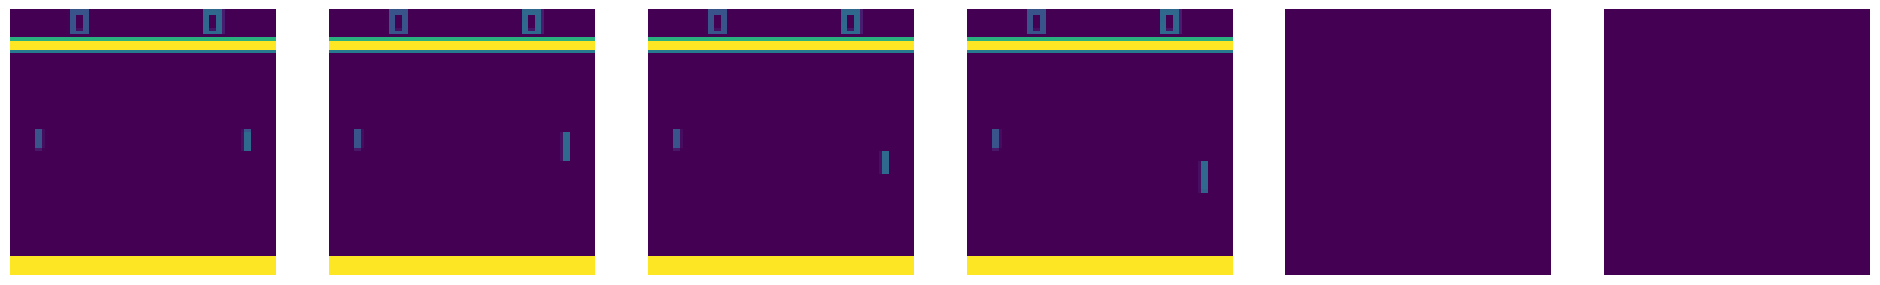

In [125]:
import matplotlib.pyplot as plt

def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def display_images(images):
    num_images = images.shape[2]
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 4))

    for i in range(num_images):
        axes[i].imshow(images[:, :, i])
        axes[i].axis('off')

    plt.show()

# Print dimensions 0, 1, 2

selected_sample = samples[6]
cogment_obs = selected_sample.actors_data["web_actor"].observation
observation = observation_space.deserialize(cogment_obs).value

display_images(observation[:,:, :])

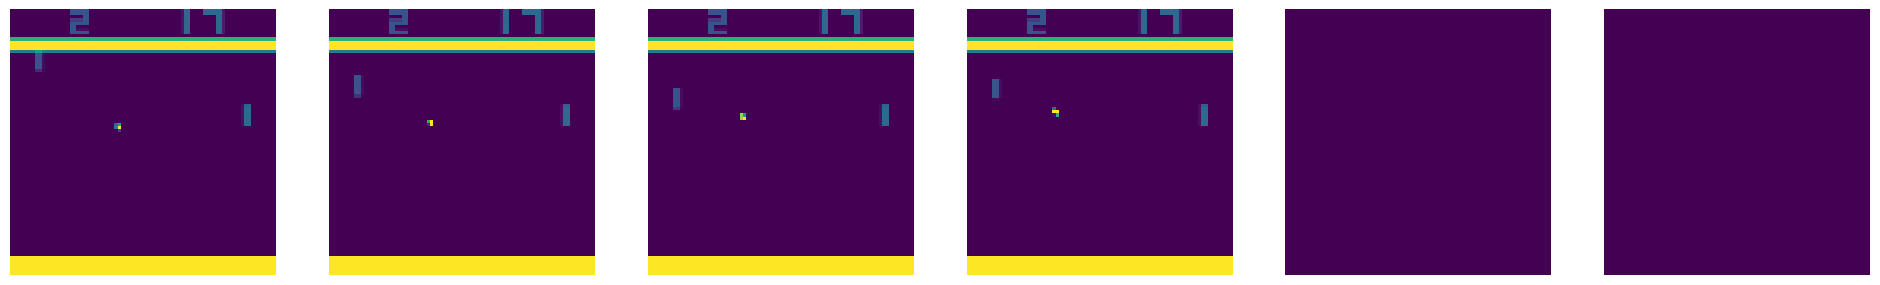

In [112]:
selected_sample = samples[2000]
cogment_obs = selected_sample.actors_data["web_actor"].observation
observation = observation_space.deserialize(cogment_obs).value

display_images(observation[:,:, :])

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create the input widgets
index_slider = widgets.IntSlider(
    min=0,
    max=len(samples) - 1,
    description='Observation Index:'
)


# Define the output widget
output_widget = widgets.Output()


# Create the function to update the output
def update_output(change):
    selected_index = index_slider.value
    selected_sample = samples[selected_index]
    cogment_obs = selected_sample.actors_data["web_actor"].observation
    observation = observation_space.deserialize(cogment_obs).value
    # Call your function with the selected image
    
    result = display_image(observation[:, : , 0:4])

    with output_widget:
        clear_output()
        
        # Display the result
        display(result)

# Register the update function to be called when the slider value changes
index_slider.observe(update_output, 'value')

# # Display the widgets
display(index_slider)
display(output_widget, clear=False)